<a href="https://colab.research.google.com/github/rahiakela/kaggle-competition-projects/blob/plant-pathology-2020-competition/1_plant_pathology_2020_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Plant Pathology 2020 - FGVC7

**Identify the category of foliar diseases in apple trees**

This competition is part of the Fine-Grained Visual Categorization [FGVC7](https://sites.google.com/view/fgvc7/home) workshop at the Computer Vision and Pattern Recognition Conference [CVPR 2020](http://cvpr2020.thecvf.com/). A panel will review the top submissions for the competition based on the description of the methods provided. From this, a subset may be invited to present their results at the workshop. Attending the workshop is not required to participate in the competition, however only teams that are attending the workshop will be considered to present their work.

There is no cash prize for this competition. Attendees presenting in person are responsible for all costs associated with travel, expenses, and fees to attend CVPR 2020. PLEASE NOTE: CVPR frequently sells out early, we cannot guarantee CVPR registration after the competition's end. If you are interested in attending, please plan ahead.

Reference:

https://www.kaggle.com/shawon10/plant-pathology-eda-and-deep-cnn

https://www.kaggle.com/shawon10/plant-pathology-classification-using-densenet121

https://www.kaggle.com/xhlulu/plant-pathology-very-concise-tpu-efficientnet

https://www.kaggle.com/tarunpaparaju/plant-pathology-2020-eda-models

https://heartbeat.fritz.ai/reviewing-efficientnet-increasing-the-accuracy-and-robustness-of-cnns-6aaf411fc81d

https://www.kaggle.com/code1110/how-to-submit-from-google-colab

https://colab.research.google.com/drive/17MsV4f8Bap8y2MU8BcKBNXRdTNE2ftP3


## Problem Statement

Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.

## Specific Objectives

Objectives of ‘Plant Pathology Challenge’ are to train a model using images of training dataset to:

1. Accurately classify a given image from testing dataset into different diseased category or a healthy leaf; 
2. Accurately distinguish between many diseases, sometimes more than one on a single leaf; 
3. Deal with rare classes and novel symptoms; 
4. Address depth perception—angle, light, shade, physiological age of the leaf; and 
5. Incorporate expert knowledge in identification, annotation, quantification, and guiding computer vision to search for relevant features during learning.

## Data Description

Given a photo of an apple leaf, can you accurately assess its health? This competition will challenge you to distinguish between leaves which are healthy, those which are infected with apple rust, those that have apple scab, and those with more than one disease.

### Files

**train.csv**
* image_id: the foreign key for the parquet files
* combinations: one of the target labels
* healthy: one of the target labels
* rust: one of the target labels
* scab: one of the target labels

**images**

A folder containing the train and test images, in jpg format.

**test.csv**

image_id: the foreign key for the parquet files

**sample_submission.csv**
image_id: the foreign key for the parquet files
combinations: one of the target labels
healthy: one of the target labels
rust: one of the target labels
scab: one of the target labels

## Setup

In [ ]:
# install efficientnet
!pip install -U efficientnet==0.0.4

In [ ]:
# downloading efficientnet model
! export MODEL=efficientnet-b5
! wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/ckpts/efficientnet-b5.tar.gz
! tar xf efficientnet-b5.tar.gz

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import DenseNet121, ResNet50
import efficientnet as efn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

## Load dataset from Kaggle

Let's donload datasets from Kaggle.

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

First of all, needs to copy kaggle.json file to .kaggle directory

In [ ]:
# copy kaggle.json file to .kaggle directory
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# show all availabe datasets
!kaggle datasets list

In [ ]:
# Try to downlaod data for the plant-pathology-2020 challenge.
!kaggle competitions download -c plant-pathology-2020-fgvc7

### Unzip dataset

In [ ]:
import os, shutil
import zipfile

# path to the directory where the original dataset was uncompressed
original_dataset_dir = 'kaggle_plant_pathology_2020_data'

# remove directories if it already exists
shutil.rmtree(original_dataset_dir, ignore_errors=True)

# create directories
os.mkdir(original_dataset_dir)

In [ ]:
# unzip dataset
with zipfile.ZipFile("plant-pathology-2020-fgvc7.zip","r") as zip_ref:
    zip_ref.extractall(original_dataset_dir)

### Load label and paths

Load train and test csv files.

In [ ]:
train = pd.read_csv(original_dataset_dir + '/train.csv')
test = pd.read_csv(original_dataset_dir + '/test.csv')
sub = pd.read_csv(original_dataset_dir + '/sample_submission.csv')

print(train.shape, test.shape)

(1821, 5) (1821, 1)


In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


### Plot some training plant images

In [ ]:
import cv2

x = train['image_id']
img_size = 100

In [ ]:
# total image 
train['image_id'].count()

1821

In [ ]:
train_image = []
for name in train['image_id']:
  path = os.path.join(original_dataset_dir + '/images/', name + '.jpg')
  img = cv2.imread(path)
  image = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
  train_image.append(image)

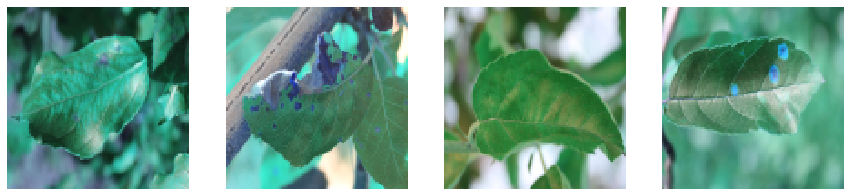

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
  ax[i].set_axis_off()
  ax[i].imshow(train_image[i])

### Plot some testing plant images

In [ ]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [ ]:
test_images = []
for name in test['image_id']:
  path = os.path.join(original_dataset_dir + '/images/', name + '.jpg')
  img = cv2.imread(path)
  image = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
  test_images.append(image)

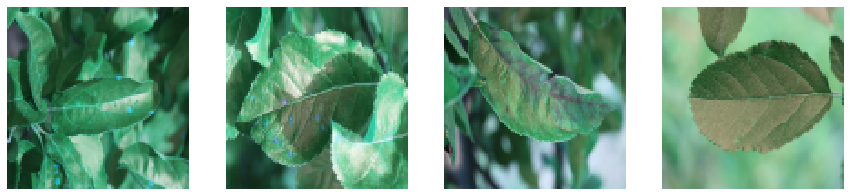

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
  ax[i].set_axis_off()
  ax[i].imshow(test_images[i])

## Prepare training/test by transforming image to array

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

# transforming train image to array
X_train = np.ndarray(shape=(len(train_image), img_size, img_size, 3), dtype=np.float32)

i = 0
for image in train_image:
  X_train[i] = img_to_array(image)
  i = i + 1

X_train = X_train / 255
print(f'Train Shape: {X_train.shape}')

Train Shape: (1821, 100, 100, 3)


In [ ]:
# transforming test image to array
X_test = np.ndarray(shape=(len(test_images), img_size, img_size, 3), dtype=np.float32)

i = 0
for image in test_images:
  X_test[i] = img_to_array(image)
  i = i + 1

X_test = X_test / 255
print(f'Train Shape: {X_test.shape}')

Train Shape: (1821, 100, 100, 3)


In [ ]:
# prepare labels
y = train.copy()
y.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
# remove image_id column
del y['image_id']
y.head()

,healthy,multiple_diseases,rust,scab
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0


In [ ]:
# convert labels to array
y_train = np.array(y.values)
print(y_train.shape, y_train[0])

(1821, 4) [0 0 0 1]


In [ ]:
print(y_train.shape, y_train[1])

(1821, 4) [0 1 0 0]


### Prepare train, test and validation set

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Define the base model

In [ ]:
def define_model():
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(img_size, img_size, 3), activation='relu'))
  model.add(BatchNormalization())   # # Normalize the activations of the previous layer at each batch

  model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Flatten())   # Flatten the input so that could feed into dense layer

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(4, activation='softmax'))

  optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  model.summary()

  return model

### Build the model

In [ ]:
model = define_model()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model1.h5', verbose=1, save_best_only=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 32)        2

### Train the model

In [ ]:
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360,        # Degree range for random rotations
                             width_shift_range=0.2,     # Range for random horizontal shifts
                             height_shift_range=0.2,    # Range for random vertical shifts
                             zoom_range=0.2,            # Range for random zoom
                             horizontal_flip=True,      # Randomly flip inputs horizontally
                             vertical_flip=True)        # Randomly flip inputs vertically

datagen.fit(X_train)

# Fits the model on batches with real-time data augmentation
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              steps_per_epoch=X_train.shape[0] // 32,
                              epochs=120,
                              callbacks=[annealer, checkpoint],
                              validation_data=(X_val, Y_val),
                              verbose=1)

### Plot the validation accuracy and loss

In [ ]:
def display_training_curves(training, validation, title, subplot):
  """
  Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
  """
  if subplot%10==1: # set up the subplots on the first call
      plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
      plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

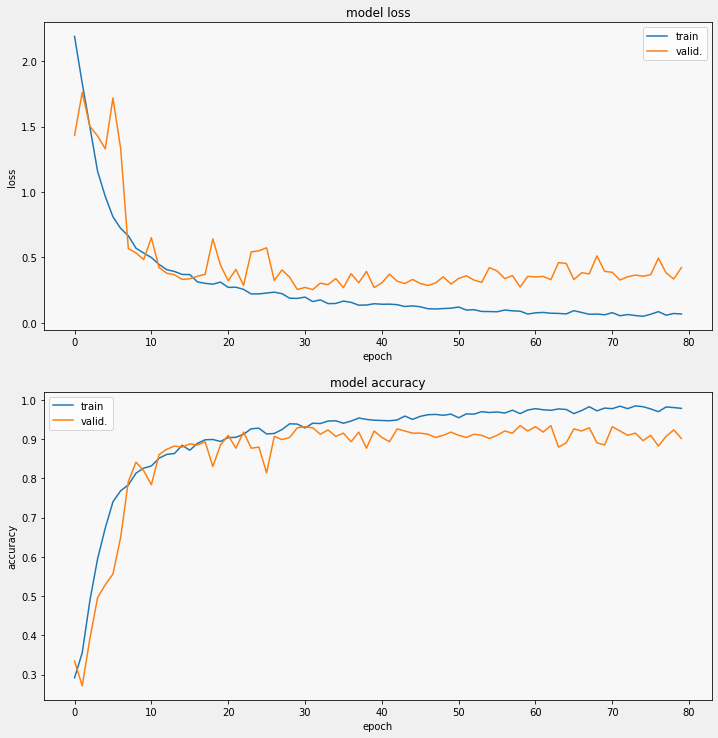

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

### Make prediction

In [ ]:
predict = model.predict(X_test)
all_predict = np.ndarray(shape=(test.shape[0], 4), dtype=np.float32)

for i in range(0, test.shape[0]):
  for j in range(0, 4):
    if predict[i][j] == max(predict[i]):
      all_predict[i][j] = 1
    else:
      all_predict[i][j] = 0

### Submit Prediction

In [ ]:
def prepare_prediction():

  submit_file = 'submission.csv'

  healthy = [y_test[0] for y_test in all_predict]
  multiple_diseases = [y_test[1] for y_test in all_predict]
  rust = [y_test[2] for y_test in all_predict]
  scab = [y_test[3] for y_test in all_predict]

  df = {
    'image_id': test.image_id,
    'healthy': healthy,
    'multiple_diseases': multiple_diseases,
    'rust': rust,
    'scab': scab
  }
  data = pd.DataFrame(df)

  # make a submission file
  data.to_csv('submission.csv', index=False, header=True)

  return submit_file

Finally by running the following command, you can submit your file to kaggle from google colab!

In [ ]:
submition_csv = prepare_prediction()
# submit the file to kaggle
!kaggle competitions submit plant-pathology-2020-fgvc7 -f submition_csv -m 'Yeah! I submit my file through the Google Colab!'

## Define model based on DenseNet121

Densely Connected Convolutional Networks (DenseNets), are a popular CNN-based ImageNet used for a variety of applications, inclusing classification, segmentation, localization, etc. Most models before DenseNet relied solely on network depth for representational power. Instead of drawing representational power from extremely deep or wide architectures, DenseNets exploit the potential of the network through feature reuse. This was the main motivation behind the DenseNet architecture. Now let us train DenseNet on leaf images and evaluate its performance.

In [ ]:
def build_densenet():

  densenet = DenseNet121(weights='imagenet', include_top=False)

  inputs = Input(shape=(img_size, img_size, 3))
  x = Conv2D(3, (3, 3), padding='same')(inputs)

  x = densenet(x)

  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  # multi output
  output = Dense(4, activation='softmax', name='root')(x)

  # model
  model = Model(inputs, output)

  optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  model.summary()

  return model

### Build the model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model2.h5', verbose=1, save_best_only=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 3)       84        
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2624

### Train the model

In [ ]:
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360,        # Degree range for random rotations
                             width_shift_range=0.2,     # Range for random horizontal shifts
                             height_shift_range=0.2,    # Range for random vertical shifts
                             zoom_range=0.2,            # Range for random zoom
                             horizontal_flip=True,      # Randomly flip inputs horizontally
                             vertical_flip=True)        # Randomly flip inputs vertically

datagen.fit(X_train)

# Fits the model on batches with real-time data augmentation
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              steps_per_epoch=X_train.shape[0] // 32,
                              epochs=80,
                              callbacks=[annealer, checkpoint],
                              validation_data=(X_val, Y_val),
                              verbose=1)

### Plot the validation accuracy and loss

In [ ]:
def display_training_curves(training, validation, title, subplot):
  """
  Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
  """
  if subplot%10==1: # set up the subplots on the first call
      plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
      plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

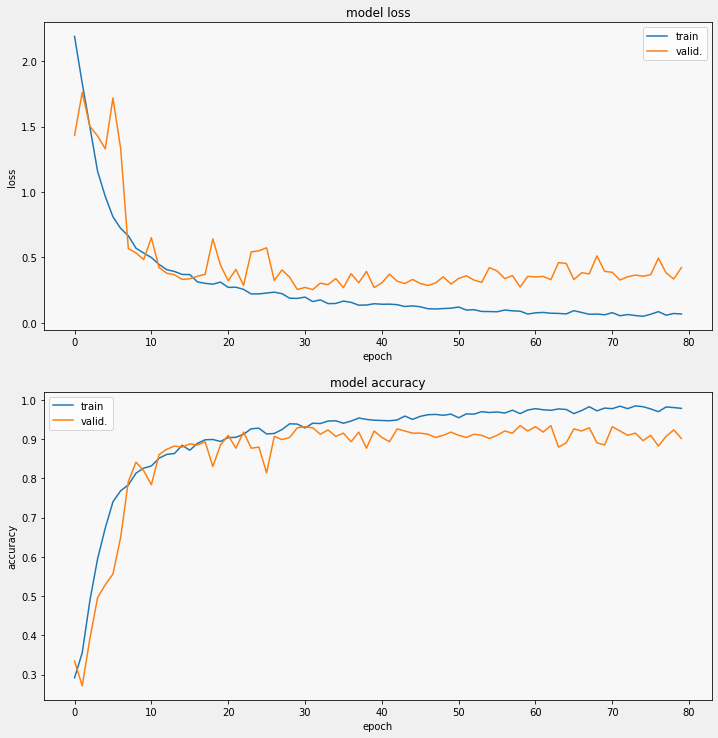

In [ ]:
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


### Make prediction



In [ ]:
predict = model.predict(X_test)
all_predict = np.ndarray(shape=(test.shape[0], 4), dtype=np.float32)

for i in range(0, test.shape[0]):
  for j in range(0, 4):
    if predict[i][j] == max(predict[i]):
      all_predict[i][j] = 1
    else:
      all_predict[i][j] = 0

### Submit prediction

Finally by running the following command, you can submit your file to kaggle from google colab!

In [ ]:
submition_csv = prepare_prediction()
# submit the file to kaggle
!kaggle competitions submit plant-pathology-2020-fgvc7 -f submition_csv -m 'Yeah! I submit my file through the Google Colab!'

100% 45.2k/45.2k [00:02<00:00, 15.7kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

## Define model based on EfficientNet

EfficientNet is another popular (more recent) CNN-based ImageNet model which achieved the SOTA on several image-based tasks in 2019. EfficientNet performs model scaling in an innovative way to achieve excellent accuracy with significantly fewer parameters. It achieves the same if not greater accuracy than ResNet and DenseNet with a mcuh shallower architecture. Now let us train EfficientNet on leaf images and evaluate its performance.

In [ ]:
def build_efficientnet():

  EfficientNet = efn.EfficientNetB7(weights='imagenet', include_top=False)

  inputs = Input(shape=(img_size, img_size, 3))
  x = Conv2D(3, (3, 3), padding='same')(inputs)

  x = EfficientNet(x)

  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x)

  # multi output
  output = Dense(4, activation='softmax', name='root')(x)

  # model
  model = Model(inputs, output)

  optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  model.summary()

  return model

### Build the model

In [ ]:
model = build_efficientnet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model3.h5', verbose=1, save_best_only=True)

ValueError: ignored

### Train the model

In [ ]:
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360,        # Degree range for random rotations
                             width_shift_range=0.2,     # Range for random horizontal shifts
                             height_shift_range=0.2,    # Range for random vertical shifts
                             zoom_range=0.2,            # Range for random zoom
                             horizontal_flip=True,      # Randomly flip inputs horizontally
                             vertical_flip=True)        # Randomly flip inputs vertically

datagen.fit(X_train)

# Fits the model on batches with real-time data augmentation
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              steps_per_epoch=X_train.shape[0] // 32,
                              epochs=80,
                              callbacks=[annealer, checkpoint],
                              validation_data=(X_val, Y_val),
                              verbose=1)